In [1]:
import os
from pathlib import Path

import sys

current_path = %pwd
current_path = Path(current_path)
sys.path.insert(0, str(current_path.parent))

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='1'

import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

from data import preprocessing
from models import training, baseline_10x10
from metrics import get_val_metric_v

preprocessing._VERSION = 'data_v1'
pad_range = (39, 49)
time_range = (266, 276)
data = preprocessing.read_csv_2d(pad_range=pad_range, time_range=time_range)

data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

In [2]:
import re

In [3]:
N_LAST = 50

model_path = Path('../saved_models/baseline_10x10_normed')
models = model_path.glob("generator_*.h5")
expr = re.compile(r'generator_([0-9]*)\.h5')
def getnum(model_name):
    num, = re.match(expr, model_name).groups()
    return int(num)

models = {getnum(m.name) : m for m in models}
models = [models[i].as_posix() for i in sorted(models)[-N_LAST:]]
models = [tf.keras.models.load_model(m) for m in models]

In [12]:
avg_model = training.average(models[-20:])

In [5]:
unscale = lambda x: 10**x - 1

def get_model_metric(model, num_events=100000):
    imgs = unscale(
        model(
            np.random.normal(size=(num_events, baseline_10x10.LATENT_DIM)).astype('float32')
        ).numpy()
    )
    return get_val_metric_v(imgs)

In [6]:
metrics_real = get_val_metric_v(data_test)
metrics_gen = [get_model_metric(m) for m in models]

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

from plotting import compare_two_dists, _get_stats

In [8]:
def stats_from_metrics(metrics):
    stats0 = [_get_stats(metric[:,0]) for metric in metrics]
    stats1 = [_get_stats(metric[:,1]) for metric in metrics]
    
    center_values = np.array(
        [(s0.mean, s0.width, s1.mean, s1.width)
         for s0, s1 in zip(stats0, stats1)]
    )
    errors = np.array(
        [(s0.mean_err, s0.width_err, s1.mean_err, s1.width_err)
         for s0, s1 in zip(stats0, stats1)]
    )
    
    return center_values, errors

In [9]:
stats_gen , stats_gen_err  = stats_from_metrics(metrics_gen)
stats_real, stats_real_err = stats_from_metrics([metrics_real])

In [10]:
stats_err = (stats_gen_err**2 + stats_real_err**2)**0.5
delta_significance = (stats_gen - stats_real) / stats_err

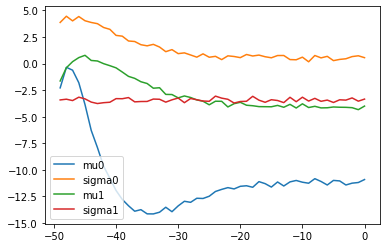

In [11]:
for sig, label in zip(delta_significance.T, ['mu0', 'sigma0', 'mu1', 'sigma1']):
    plt.plot(-np.arange(len(sig))[::-1], sig, label=label);
plt.legend();

In [13]:
metrics_gen_avg = get_model_metric(avg_model)
stats_gen_avg, stats_gen_avg_err = stats_from_metrics([metrics_gen_avg])
stats_avg_err = (stats_gen_avg_err**2 + stats_real_err**2)**0.5
delta_significance_avg = (stats_gen_avg - stats_real) / stats_avg_err

In [14]:
print(f'   real mu0 = {stats_real   [0,0]:.4f} +/- {stats_real_err   [0,0]:.4f}')
print(f'avg gen mu0 = {stats_gen_avg[0,0]:.4f} +/- {stats_gen_avg_err[0,0]:.4f}')
print(f'        (delta significance = {delta_significance_avg[0, 0]:.2f})')
print('-' * 15)

print(f'   real std0 = {stats_real   [0,1]:.4f} +/- {stats_real_err   [0,1]:.4f}')
print(f'avg gen std0 = {stats_gen_avg[0,1]:.4f} +/- {stats_gen_avg_err[0,1]:.4f}')
print(f'        (delta significance = {delta_significance_avg[0, 1]:.2f})')
print('-' * 15)

print(f'   real mu1 = {stats_real   [0,2]:.4f} +/- {stats_real_err   [0,2]:.4f}')
print(f'avg gen mu1 = {stats_gen_avg[0,2]:.4f} +/- {stats_gen_avg_err[0,2]:.4f}')
print(f'        (delta significance = {delta_significance_avg[0, 2]:.2f})')
print('-' * 15)

print(f'   real std1 = {stats_real   [0,3]:.4f} +/- {stats_real_err   [0,3]:.4f}')
print(f'avg gen std1 = {stats_gen_avg[0,3]:.4f} +/- {stats_gen_avg_err[0,3]:.4f}')
print(f'        (delta significance = {delta_significance_avg[0, 3]:.2f})')
print('-' * 15)

   real mu0 = 4.1918 +/- 0.0013
avg gen mu0 = 4.1769 +/- 0.0002
        (delta significance = -11.25)
---------------
   real std0 = 0.0653 +/- 0.0009
avg gen std0 = 0.0657 +/- 0.0001
        (delta significance = 0.47)
---------------
   real mu1 = 4.3863 +/- 0.0025
avg gen mu1 = 4.3763 +/- 0.0004
        (delta significance = -3.92)
---------------
   real std1 = 0.1260 +/- 0.0018
avg gen std1 = 0.1195 +/- 0.0003
        (delta significance = -3.48)
---------------


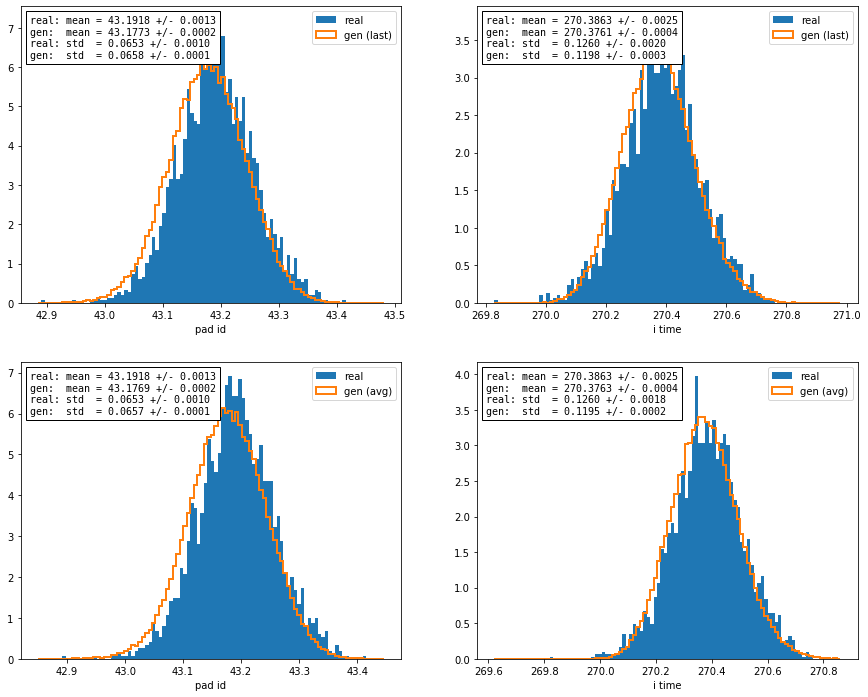

In [15]:
metrics_gen_last = metrics_gen[-1]

mean_padid_real     = metrics_real    [:,0] + 39
mean_padid_gen_last = metrics_gen_last[:,0] + 39
mean_padid_gen_avg  = metrics_gen_avg [:,0] + 39

mean_time_real     = metrics_real    [:,1] + 266
mean_time_gen_last = metrics_gen_last[:,1] + 266
mean_time_gen_avg  = metrics_gen_avg [:,1] + 266

plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1); compare_two_dists(mean_padid_real, mean_padid_gen_last, 'pad id', tag='last')
plt.subplot(2, 2, 2); compare_two_dists(mean_time_real , mean_time_gen_last , 'i time', tag='last')
plt.subplot(2, 2, 3); compare_two_dists(mean_padid_real, mean_padid_gen_avg , 'pad id', tag='avg' )
plt.subplot(2, 2, 4); compare_two_dists(mean_time_real , mean_time_gen_avg  , 'i time', tag='avg' )

In [16]:
avg_imgs = unscale(
    avg_model(
        np.random.normal(size=(10000, baseline_10x10.LATENT_DIM)).astype('float32')
    ).numpy()
)

In [17]:
from matplotlib.colors import LogNorm

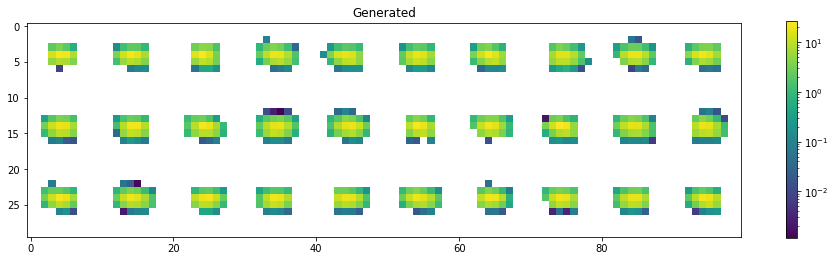

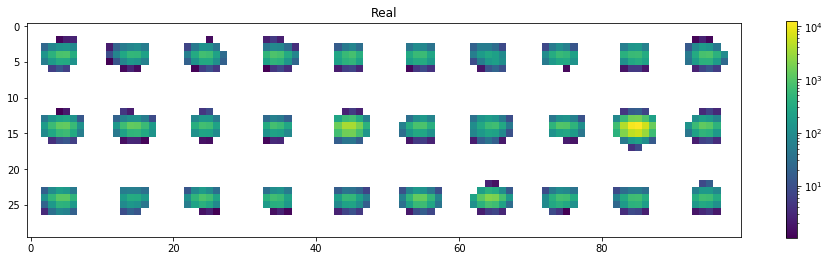

In [18]:
plt.figure(figsize=(16, 4))
cb_img = plt.imshow(
    avg_imgs[:30].reshape(3, 10, 10, 10).transpose(0, 2, 1, 3).reshape(30, 100),
    norm=LogNorm()
);
plt.colorbar(cb_img);
plt.title("Generated")

plt.figure(figsize=(16, 4))
cb_img = plt.imshow(
    data_test[:30].reshape(3, 10, 10, 10).transpose(0, 2, 1, 3).reshape(30, 100),
    norm=LogNorm()
);
plt.colorbar(cb_img);
plt.title("Real");


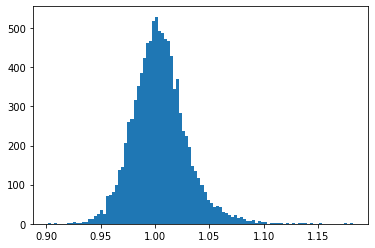

In [20]:
plt.hist((avg_imgs / 100).sum(axis=(1, 2)), bins=100);

In [22]:
with open(str(model_path.joinpath('generated.dat')), 'w') as f:
    for event in avg_imgs:
        for ipad, time_distr in enumerate(event, pad_range[0]):
            for itime, amp in enumerate(time_distr, time_range[0]):
                if amp < 1.:
                    continue
                f.write(" {:2d} {:3d} {:8.3e} ".format(ipad, itime, amp / 100))
        f.write('\n')